In [27]:
import psycopg2
import config as creds
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

### Connecting to the Database

In [2]:
user=creds.PGUSER
password=creds.PGPASSWORD
host=creds.PGHOST
port=5432
database=creds.PGDATABASE

In [3]:
engine_str=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"

In [4]:
engine = create_engine(engine_str)

In [5]:
conn = engine.raw_connection()
print('Connected')

Connected


In [6]:
cur = conn.cursor()
print('Cursor created')

Cursor created


### Checking to see what data is hosted inside the database

In [7]:
query1='''
SELECT * 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH; 
'''

In [8]:
df1=pd.read_sql(query1,conn)

In [12]:
pd.set_option('display.max_columns',None)

In [13]:
df1.head()

,id,pid,dcrealpropertyid,ward,postalcode,yearbuilt,reportingyear,reportstatus,primarypropertytype_selfselect,taxrecordfloorarea,reportedbuildinggrossfloorarea,energystarscore,month,kbtu,elegas,id,date,awnd,cldd,htdd,snow,tavg,tmax,tmin,wdf2,wdf5,wsf2,wsf5,weatheryear,month,kbtusqft
0,0,PM4373175,0171_0814,2,20006,1893,2016,In Compliance,2,137024.0,176170.0,0.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1,0.0
1,3,PM1331555,0248_0812,2,20005,1921,2016,In Compliance,7,146425.0,222000.0,52.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1,0.0
2,4,PM3299991,0139_0817,2,20036,1963,2016,In Compliance,10,101337.0,73168.0,38.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1,0.0
3,5,PM4357992,0494_0860,6,20024,1968,2016,In Compliance,10,80612.0,60000.0,87.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1,0.0
4,6,PM3632510,0182_0083,2,20036,2001,2016,In Compliance,2,184556.0,158819.0,49.0,1,0.0,N,72,2016-01,9.4,0.0,930.0,18.8,35.0,42.6,27.4,330.0,280.0,36.0,44.0,2016,1,0.0


In [10]:
df1['kbtusqft']=df1['kbtu']/df1['taxrecordfloorarea']

In [16]:
query2='''
SELECT * 
FROM buildings_data b
LEFT OUTER join noaa_data n
ON b.REPORTINGYEAR = n.WEATHERYEAR
WHERE b.MONTH = n.MONTH
AND b.KBTU > 0; 
'''

In [17]:
df2=pd.read_sql(query2, conn)

In [18]:
df2['kbtusqft']=df2['kbtu']/df2['taxrecordfloorarea']

In [32]:
df2['datetime']=pd.to_datetime(df2['date'])

In [33]:
df2.head()

,id,pid,dcrealpropertyid,ward,postalcode,yearbuilt,reportingyear,reportstatus,primarypropertytype_selfselect,taxrecordfloorarea,reportedbuildinggrossfloorarea,energystarscore,month,kbtu,elegas,id,date,awnd,cldd,htdd,snow,tavg,tmax,tmin,wdf2,wdf5,wsf2,wsf5,weatheryear,month,kbtusqft,datetime
0,2170,PM6211783,5583_0803,0,0,1943,2019,In Compliance,7,10305.0,62306.0,19.0,1,104735.6,N,108,2019-01,9.6,0.0,860.0,11.5,37.2,44.3,30.2,320.0,310.0,36.0,46.0,2019,1,10.163571,2019-01-01
1,842,PM1034322,0197_0853,2,20036,1959,2018,In Compliance,10,144462.0,115470.0,82.0,1,458508.5,N,96,2018-01,9.8,0.0,906.0,1.2,35.8,44.7,26.8,300.0,310.0,36.0,49.0,2018,1,3.173904,2018-01-01
2,845,PM4007835,1601_2421,3,20016,1971,2018,In Compliance,7,208138.0,210807.0,1.0,1,3292421.9,N,96,2018-01,9.8,0.0,906.0,1.2,35.8,44.7,26.8,300.0,310.0,36.0,49.0,2018,1,15.818457,2018-01-01
3,847,PM6453431,0198_0039,2,20036,1944,2018,In Compliance,7,1050362.0,559168.0,12.0,1,1526330.0,N,96,2018-01,9.8,0.0,906.0,1.2,35.8,44.7,26.8,300.0,310.0,36.0,49.0,2018,1,1.453147,2018-01-01
4,851,PM3353544,0435_0837,6,20024,1979,2018,In Compliance,10,256738.0,819867.0,0.0,1,2949500.0,N,96,2018-01,9.8,0.0,906.0,1.2,35.8,44.7,26.8,300.0,310.0,36.0,49.0,2018,1,11.488366,2018-01-01


In [34]:
df2.columns

Index(['id', 'pid', 'dcrealpropertyid', 'ward', 'postalcode', 'yearbuilt',
       'reportingyear', 'reportstatus', 'primarypropertytype_selfselect',
       'taxrecordfloorarea', 'reportedbuildinggrossfloorarea',
       'energystarscore', 'month', 'kbtu', 'elegas', 'id', 'date', 'awnd',
       'cldd', 'htdd', 'snow', 'tavg', 'tmax', 'tmin', 'wdf2', 'wdf5', 'wsf2',
       'wsf5', 'weatheryear', 'month', 'kbtusqft', 'datetime'],
      dtype='object')

In [56]:
df2.primarypropertytype_selfselect.unique()

array(['7', '10', '3', '2', '17', '14', '6', '15', '11', '4', '19', '16',
       '9', '13', '8', '5', '18'], dtype=object)

In [47]:
from sklearn.model_selection import train_test_split as tts

TARGET = ['kbtusqft']
COLS =['dcrealpropertyid', 'ward', 'postalcode', 'yearbuilt',
       'reportingyear','primarypropertytype_selfselect', 'month', 'elegas', 'id', 
       'awnd', 'cldd', 'htdd', 'snow', 'tavg','datetime'
       'wdf2', 'wdf5', 'wsf2', 'wsf5', 'weatheryear']


def make_sklearn_data(df=df1, splits=True, train_size=0.8, target=TARGET, cols=COLS):
    # Add the datetime column back to the main dataframe
    df = df.reset_index()
    X, y = df[cols], df[target]
    
    if splits:
        return tts(X, y, train_size=train_size)
    return X, y

<AxesSubplot:xlabel='datetime_cos', ylabel='datetime_sin'>

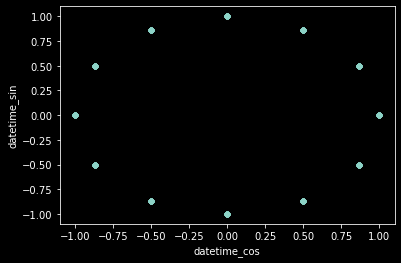

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin


class CyclicEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_extract="month"):
        if date_extract not in {"minute", "hour", "week", "month", "year"}:
            raise ValueError(f"specify correct date component to extract, not {date_extract}")
        self.date_extract = date_extract
    
    def get_date_component(self, x):
        if self.date_extract == "month":
            return x.dt.month
        elif self.date_extract == "year":
            return x.dt.year
        else:
            raise NotImplementedError(f"{self.date_extract} date component not implemented yet")
            
    def fit(self, X, y=None):
        self.cycle_max_ = self.get_date_component(X).max()
        return self

    def transform(self, X,  y=None):
        cols = []
        names = []
        x = self.get_date_component(X)
        xn = 2 * np.pi * x / self.cycle_max_
        cols.append(np.cos(xn))
        names.append(f"{X.name}_cos")
        cols.append(np.sin(xn))
        names.append(f"{X.name}_sin")
        return pd.DataFrame(np.asarray(cols).T, columns=names)

    
ce = CyclicEncoder().fit_transform(df2.reset_index()["datetime"])
ce.plot(x="datetime_cos", y="datetime_sin", kind="scatter")

### Construct a Pipeline

In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

In [50]:
engineering=Pipeline([
    ('column_selection', ColumnTransformer([('time_components', FeatureUnion([
        ('month', CyclicEncoder(date_extract='month')), ('year', CyclicEncoder(date_extract='year')), 
        ]),'date_time'),('encoder', OneHotEncoder(handle_unknown='ignore'), df2['ward'])], remainder='passthrough')),
])

#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), df2['ward'])], remainder='passthrough')

In [52]:
X, y =make_sklearn_data(splits=False)
engineering.fit_transform(X).shape

KeyError: "['datetimewdf2'] not in index"

In [36]:
conn.close()
print('Closed')

Closed
